# Task02 數據分析 EDA

## Task02 目標及內容
### 目標
>1. 初步分析變量間、變量和預測目標間相互關係  
2. 將初步分析結果以圖表展現總結  
3. 有助於後續特徵工程參考

### 內容
>1. 總覽數據概況  
2. 評估數據缺失及異常問題  
3. 了解預測值分布  
4. 了解特徵類型及分布  
5. 初步特徵分析  
6. 可視化  
7. 用pandas_profiling生成數據報告  

### 將目標拆解成以下問題：
>Q1：變量是否需要預處理才能確保充分發揮其應有的預測能力？  
Q2：變量的統計分布、變量間相關性、變量與預測目標間相關性等，是否能提供其他變量預測能力的信息？

## 一、pandas-profiling
>利用 pandas-profiling 對訓練及測試集所有字段進行初步統計分析。  
需注意此 report 基於一個全自動的分析結果，並不完全準確，僅能作為初步參考，幫助快速對整體數據集有粗略了解。  
(例如：數據中以 '-' 表示缺失，但 pandas-profiling 無法判定此為缺失)

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as ppf
import seaborn as sns
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',35)
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./raw_data/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('./raw_data/used_car_testA_20200313.csv', sep=' ')

### 訓練集

In [3]:
# 利用 pandas-profiling 對訓練集中所有字段進行初步統計分析
train_pfr = ppf.ProfileReport(train,minimal=True,progress_bar=False) # minimal最簡化統計項目及速度
train_pfr.to_notebook_iframe()
#train_pfr.to_file('train_profile.html')

### 測試集

In [4]:
# 利用 pandas-profiling 對測試集中所有字段進行初步統計分析
test_pfr = ppf.ProfileReport(test,title='test_data',minimal=True,progress_bar=False)
test_pfr.to_notebook_iframe()
#test_pfr.to_file('test_profile.html')

## 二、變量類型

**預測變量**
>**唯一編碼：**  
1.SaleID  

>**非唯一編碼：**  
1.name  
2.model  
3.regionCode  

>**類別變量(包括01變量）：**  
1.brand  
2.bodyType  
3.fuelType  
4.gearbox  
5.notRepairedDamage  
6.seller  
7.offerType  

>**數值變量：**  
1.power  
2.kilometer  
3.v_0-v_14  

>**日期變量：**  
1.regDate  
2.creatDate  

**預測目標 price**  
數值變量 > 回歸問題

## 三、數據缺失分析

缺失除了NA、None、NaN空值之外，也可能用字符串形式表示，因此除了isnull()判斷之外，還需注意是否有dtype異常。

### 訓練集

In [5]:
train.info()
# 利用 info() 可以快速了解各字段的類型和 isnull()的缺失部分

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

>由上述統計可知：  
1. 訓練集有null字段 -  
    model(1筆)  
    bodyType(4506筆，約3%)  
    fuelType(8680筆，約5.8%)  
    gearbox(5981筆，約4%)
2. 其中 notRepairedDamage 的 dtype 應為 float 但為 object，需進一步分析

In [6]:
train.notRepairedDamage.value_counts()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

>由上述value_counts結果可知，此字段應為 float 類型，但因缺失部分以字符串'-'表示，故數字部分也以字符串形式讀取。
因此缺失的'-'部分需替換為空值，並將整個字段轉為float形式方便後續分析。

In [7]:
train.notRepairedDamage = train.notRepairedDamage.apply(lambda x : float(x) if x!='-' else np.nan)
train.notRepairedDamage.isnull().sum()

24324

>notRepairedDamage 處理後統計缺失值共 24324 筆，占 16% 。

**訓練集缺失狀況小結**
>model(1筆)  
bodyType(4506筆，約3%)  
fuelType(8680筆，約5.8%)  
gearbox(5981筆，約4%)  
notRepairedDamage(24324筆，約16%)  

model 僅缺失一筆，可以考慮直接剔除此樣本，其他變量（尤其notRepairedDamage）需考慮其他方式補全。

### 測試集

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

由上述統計可知測試集有null字段 -  
>1. bodyType(1413筆，約2.8%)  
fuelType(2893筆，約5.8%)  
gearbox(1910筆，約3.8%)
2. 其中 notRepairedDamage 的 dtype 應為 float 但為 object，同訓練集狀況需進一步分析

In [9]:
### 和訓練集相同，對notRepairedDamage做替換及dtype轉換，並統計缺失狀況
test.notRepairedDamage = test.notRepairedDamage.apply(lambda x : float(x) if x!='-' else np.nan)
test.notRepairedDamage.isnull().sum()

8031

**測試集缺失狀況小結**
>bodyType(1413筆，約2.8%)  
fuelType(2893筆，約5.8%)  
gearbox(1910筆，約3.8%)  
notRepairedDamage(8031筆，約16%)  

測試集缺失狀況和訓練集大致相同，後續跑測試集結果時，測試集缺失部分比照訓練及進行處理即可。

## 四、數據異常值及分布分析

根據不同類型變量分別進行不同分析：

In [10]:
### 數值變量分布直方圖
def plot_count_by_column_hist(col,train,test,bins=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, figsize = (9,3))
    ax1.set_xlabel(col)
    ax1.set_ylabel('cnt')
    ax1.title.set_text(col+"_cnt_train")
    ax1.hist(train[col], bins=bins, color='blue')

    ax2.set_xlabel(col)
    ax2.set_ylabel('cnt')
    ax2.title.set_text(col+"_cnt_test")
    ax2.hist(test[col], bins=bins, color='orange')

In [11]:
### 類別變量統計柱狀圖
def plot_count_by_column_bar(col, train, test):
    cnt_train = train.groupby([col]).SaleID.agg({'cnt':np.size}).reset_index()
    cnt_test = test.groupby([col]).SaleID.agg({'cnt':np.size}).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, figsize = (9,3))
    ax1.set_xlabel(col)
    ax1.set_ylabel('cnt')
    ax1.title.set_text(col+"_cnt_train")
    ax1.bar(cnt_train[col], cnt_train.cnt, color='blue')

    ax2.set_xlabel(col)
    ax2.set_ylabel('cnt')
    ax2.title.set_text(col+"_cnt_test")
    ax2.bar(cnt_test[col],cnt_test.cnt, color='orange')

In [12]:
### 數值變量箱型圖
def boxplot_train_test(col,train,test):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey=True, figsize = (9,3))
    ax1.set_ylabel(col)
    ax1.title.set_text(col+"_boxplot_train")
    ax1.boxplot(train[col])

    ax2.set_ylabel(col)
    ax2.title.set_text(col+"_boxplot_test")
    ax2.boxplot(test[col])

In [13]:
### 數值變量小提琴圖
def violinplot_train_test(col,train,test):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey=True, figsize = (9,3))
    ax1.set_ylabel(col)
    ax1.title.set_text(col+"_violinplot_train")
    ax1.violinplot(train[col])

    ax2.set_ylabel(col)
    ax2.title.set_text(col+"_violinplot_test")
    ax2.violinplot(test[col])

### 1. 編碼變量
（包括：SaleID, name, model, regionCode）  

**SaleID**  
唯一編碼不需進行分析

**name**  
編碼變量不需進行異常值分析

分布分析：

In [14]:
print('train names:\n{}\n'.format(len(train.name.unique())))
print('test names:\n{}'.format(len(test.name.unique())))

train names:
99662

test names:
37453


name 編碼量過多，以數值變量方式做分布分析：

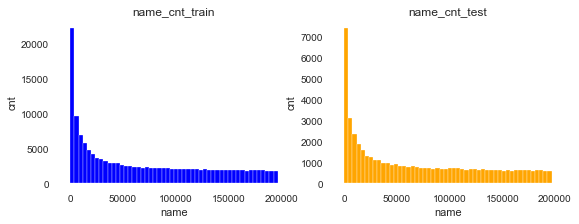

In [15]:
plot_count_by_column_hist('name',train,test,bins=50)

>由上圖可發現，name 數值較小部分汽車數量較多，推估在name編碼時以數量或其高度相關的特徵進行排序後進行編碼，後續可作為特徵構建參考。

**model**  
編碼變量不需進行異常值分析

分布分析：

In [16]:
print('train models:\n{}\n'.format(len(train.model.unique())))
print('test models:\n{}'.format(len(test.model.unique())))

train models:
249

test models:
247


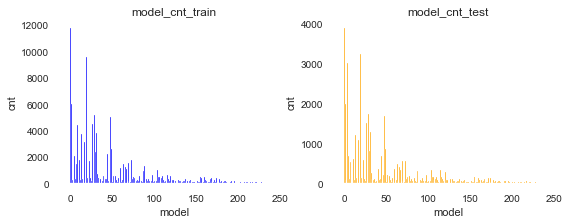

In [17]:
plot_count_by_column_bar('model',train,test)

>由上圖可發現，model 和 name 有相似狀況－數值較小部分汽車數量相對較多 (但model呈現的相關性較name低)，推估在model編碼時也以數量或其高度相關的特徵進行排序後進行編碼，後續可作為特徵構建參考。

**regionCode**  
編碼變量不需進行異常值分析

In [18]:
print('train regionCodes:\n{}\n'.format(len(train.regionCode.unique())))
print('test regionCodes:\n{}'.format(len(test.regionCode.unique())))

train regionCodes:
7905

test regionCodes:
6971


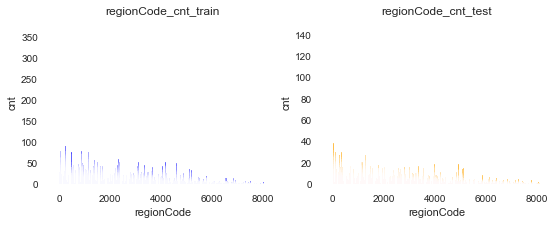

In [19]:
plot_count_by_column_bar('regionCode',train,test)

>由上圖可發現，regionCode 也有數值較小部分汽車數量相對較多的情形，但呈現的相關性又比model更低，後續結合name和model可作為特徵構建參考。

### 2. 日期變量
（包括：regDate, creatDate）  
只需要判斷是否有格式錯誤、異常久或未來日期

**regDate**

In [20]:
# 檢視年份
train['regDate_year'] = train['regDate'].apply(lambda x : int(str(x)[0:4]))
test['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))

In [21]:
print('train regDate years:\n{}\n'.format(sorted(train.regDate_year.unique())))
print('test regDate years:\n{}'.format(sorted(test.regDate_year.unique())))

train regDate years:
[1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

test regDate years:
[1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


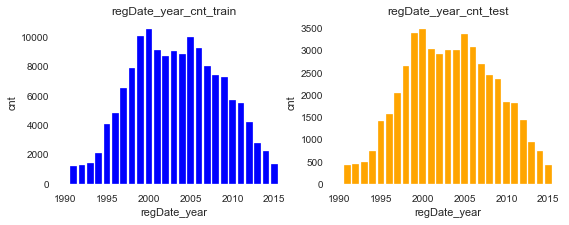

In [22]:
plot_count_by_column_bar('regDate_year',train,test)

年份並無異常狀況，且分布正常。

In [23]:
# 檢視月份
train['regDate_month'] = train['regDate'].apply(lambda x : int(str(x)[4:6]))
test['regDate_month'] = test['regDate'].apply(lambda x : int(str(x)[4:6]))

In [24]:
print('train regDate months:\n{}\n'.format(sorted(train.regDate_month.unique())))
print('test regDate months:\n{}'.format(sorted(test.regDate_month.unique())))

train regDate months:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

test regDate months:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


月份中有0月，格式有誤，以下進一步提取分析：

In [25]:
train.loc[train.regDate_month==0]
print('regDate_month=0 行數={}; 占比={}%'.format(train.loc[train.regDate_month==0].shape[0],100*round(train.loc[train.regDate_month==0].shape[0]/150000,2)))

regDate_month=0 行數=11347; 占比=8.0%


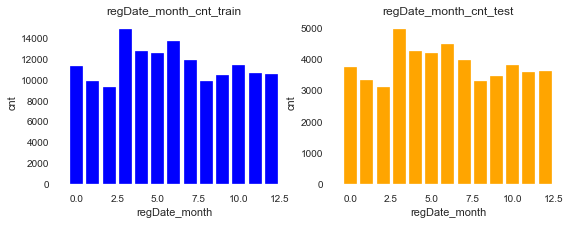

In [26]:
plot_count_by_column_bar('regDate_month',train,test)

In [27]:
# 檢視日期
train['regDate_day'] = train['regDate'].apply(lambda x : int(str(x)[6:8]))
test['regDate_day'] = test['regDate'].apply(lambda x : int(str(x)[6:8]))

In [28]:
print('train regDate days:\n{}\n'.format(sorted(train.regDate_day.unique())))
print('test regDate days:\n{}'.format(sorted(test.regDate_day.unique())))

train regDate days:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

test regDate days:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


日期只有1-12 ?

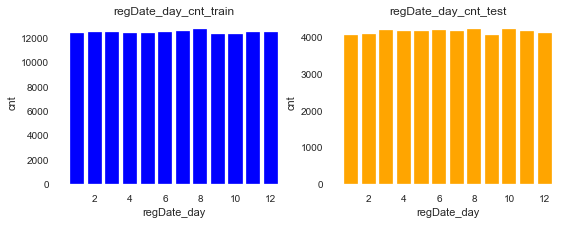

In [29]:
plot_count_by_column_bar('regDate_day',train,test)

>年份上，regDate都介於1991-2015年間，並沒有異常離群值。  
但月份有 8% 為 0，日期則只有 1-12，若要用到月份日期作為特徵需特別注意。  
分布則無特殊情況。

**creatDate**

In [30]:
# 檢視年分
train['creatDate_year'] = train['creatDate'].apply(lambda x : int(str(x)[0:4]))
test['creatDate_year'] = test['creatDate'].apply(lambda x : int(str(x)[0:4]))

In [31]:
print('train creatDate years:\n{}\n'.format(sorted(train.creatDate_year.unique())))
print('test creatDate years:\n{}'.format(sorted(test.creatDate_year.unique())))

train creatDate years:
[2015, 2016]

test creatDate years:
[2015, 2016]


In [32]:
print('train creatDate_year:\n{}\n'.format(train.creatDate_year.value_counts()))
print('test creatDate_year:\n{}'.format(test.creatDate_year.value_counts()))

train creatDate_year:
2016    149982
2015        18
Name: creatDate_year, dtype: int64

test creatDate_year:
2016    49997
2015        3
Name: creatDate_year, dtype: int64


年份絕大部分集中在2016，年份應該不能作為特徵。

In [33]:
# 檢視月份
train['creatDate_month'] = train['creatDate'].apply(lambda x : int(str(x)[4:6]))
test['creatDate_month'] = test['creatDate'].apply(lambda x : int(str(x)[4:6]))

In [34]:
print('train creatDate_month:\n{}\n'.format(train.creatDate_month.value_counts()))
print('test creatDate_month:\n{}'.format(test.creatDate_month.value_counts()))

train creatDate_month:
3     125426
4      24344
2        185
1         27
11         7
12         5
9          3
8          2
6          1
Name: creatDate_month, dtype: int64

test creatDate_month:
3     41926
4      8007
2        58
1         6
11        2
6         1
Name: creatDate_month, dtype: int64


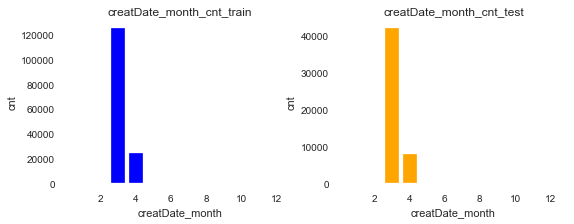

In [35]:
plot_count_by_column_bar('creatDate_month',train,test)

絕大多數月份為3月，其次為4月，且訓練及測試集分布狀況基本相同。

In [36]:
# 檢視日期
train['creatDate_day'] = train['creatDate'].apply(lambda x : int(str(x)[6:8]))
test['creatDate_day'] = test['creatDate'].apply(lambda x : int(str(x)[6:8]))

In [37]:
print('train creatDate days:\n{}\n'.format(sorted(train.creatDate_day.unique())))
print('test creatDate days:\n{}'.format(sorted(test.creatDate_day.unique())))

train creatDate days:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

test creatDate days:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


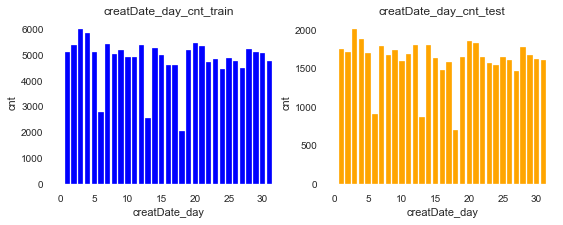

In [38]:
plot_count_by_column_bar('creatDate_day',train,test)

>creatDate並無異常值。  
分布狀況來說，年份都在2015和2016年且2016占絕大多數，年份不適合做為特徵；月份部分則大部分分布在3月，其次為4月，由於分布過於不平衡，因此具體是否為市場淡旺季差異有待研究，若想作為特徵需進一步分析；日期分布則相對平均。

### 3. 類別變量
（包括：band, bodyType, fuelType, gearbox, notRepairedDamage, seller, offerType）  
只需判斷是否有在字段描述以外的類別

**brand**

In [39]:
# 因字段表並沒有給予詳細描述，故只需簡單判斷數字是否有非整數或其他異常狀況
print('train brands:\n{}\n'.format(sorted(train.brand.unique())))
print('test brands:\n{}'.format(sorted(test.brand.unique())))
# > 結果沒有異常

train brands:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

test brands:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


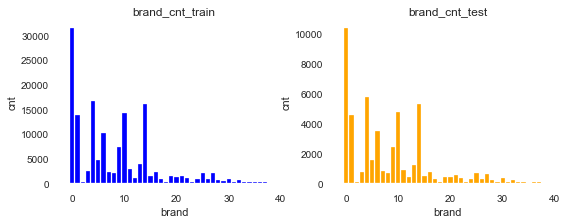

In [40]:
plot_count_by_column_bar('brand',train,test)

>brand 變量並沒有異常值。  
分布狀況由上圖可知，brand 也呈現數值較小部分汽車數量相對較多的情形，且訓練及測試集每個brand占比幾乎完全相同，具體品牌編號和數量間關係尚待研究。

**bodyType**

In [41]:
# 車身類型：豪華轎車：0，微型車：1，廂型車：2，大巴車：3，敞篷車：4，雙門汽車：5，商務車：6，攪拌車：7
print('train bodyTypes:\n{}\n'.format(sorted(train.bodyType.unique())))
print('test bodyTypes:\n{}'.format(sorted(test.bodyType.unique())))
# > 結果沒有異常

train bodyTypes:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan, 6.0, 7.0]

test bodyTypes:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan, 7.0]


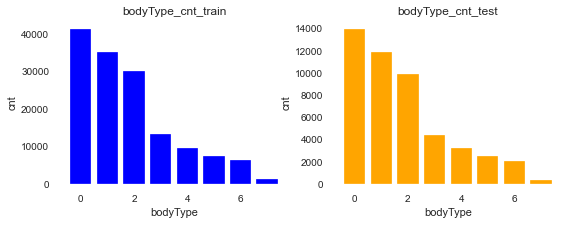

In [42]:
plot_count_by_column_bar('bodyType',train,test)

>bodyType沒有異常值。  
分布狀況由上圖可知，訓練及測試集在bodyType上分布幾乎完全相同，且各類占比大小符合一般常識中各類車輛的普遍性。

**fuelType**

In [43]:
# 燃油類型：汽油：0，柴油：1，液化石油氣：2，天然氣：3，混合動力：4，其他：5，電動：6
print('train fuelTypes:\n{}\n'.format(sorted(train.fuelType.unique())))
print('test fuelTypes:\n{}'.format(sorted(test.fuelType.unique())))
# > 結果沒有異常

train fuelTypes:
[0.0, 1.0, nan, 2.0, 3.0, 4.0, 5.0, 6.0]

test fuelTypes:
[0.0, 1.0, 2.0, 3.0, nan, 4.0, 5.0, 6.0]


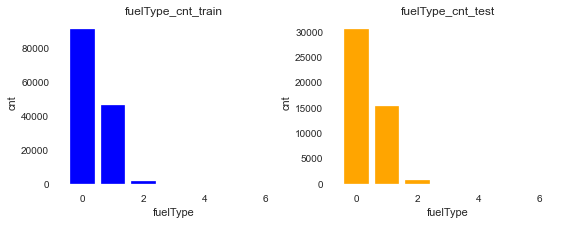

In [44]:
plot_count_by_column_bar('fuelType',train,test)

>fuelType沒有異常值。  
分布狀況由上圖可知，訓練及測試集在fuelType上分布幾乎完全相同，且各類占比大小符合一般常識中各種燃油車輛的普遍性。

**gearbox**

In [45]:
# 變速箱：手動：0，自動：1
print('train gearboxes:\n{}\n'.format(sorted(train.gearbox.unique())))
print('test gearboxes:\n{}'.format(sorted(test.gearbox.unique())))
# > 結果沒有異常

train gearboxes:
[0.0, 1.0, nan]

test gearboxes:
[0.0, 1.0, nan]


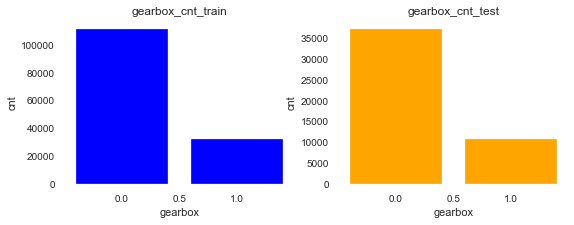

In [46]:
plot_count_by_column_bar('gearbox',train,test)

>gearbox沒有異常值。  
分布狀況由上圖可知，大部分汽車為手動。這是否表示大部分駕駛偏好手動？是否影響自動車輛市場供需？

**notRepairedDamage**

In [47]:
# 汽車有尚未修復的損壞：是：0，否：1
print('train notRepairedDamage:\n{}\n'.format(sorted(train.notRepairedDamage.unique())))
print('test notRepairedDamage:\n{}'.format(sorted(test.notRepairedDamage.unique())))
# > 結果沒有異常

train notRepairedDamage:
[0.0, nan, 1.0]

test notRepairedDamage:
[0.0, 1.0, nan]


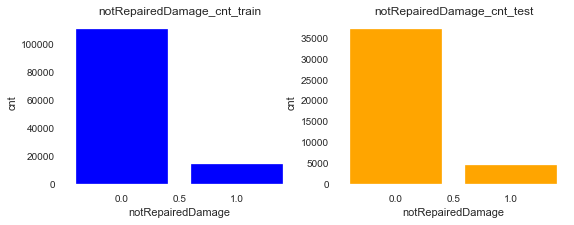

In [48]:
plot_count_by_column_bar('notRepairedDamage',train,test)

>notRepairedDamage沒有異常值。  
分布狀況由上圖可知，大部分汽車有尚未修復的損壞，後續可考慮和車齡或公里數結合判斷車況。

**seller**

In [49]:
# 銷售方：個體：0，非個體：1
print('train sellers:\n{}\n'.format(sorted(train.seller.unique())))
print('test sellers:\n{}'.format(sorted(test.seller.unique())))
# > 結果沒有異常

train sellers:
[0, 1]

test sellers:
[0]


In [50]:
print('train sellers:\n{}\n'.format(train.seller.value_counts()))
print('test sellers:\n{}'.format(test.seller.value_counts()))

train sellers:
0    149999
1         1
Name: seller, dtype: int64

test sellers:
0    50000
Name: seller, dtype: int64


>seller沒有異常值，且幾乎全部為個體賣家，僅訓練數據中有少部分非個體賣家，後續此變量可剔除。

**offerType**

In [51]:
# 報價類型：提供：0，請求：1
print('train offerTypes:\n{}\n'.format(sorted(train.offerType.unique())))
print('test offerTypes:\n{}'.format(sorted(test.offerType.unique())))
# > 結果沒有異常

train offerTypes:
[0]

test offerTypes:
[0]


>offerType沒有異常值，且全部為提供報價，後續此變量可剔除。

### 4. 數值變量
（包括：power, kilometer, v_0-v_14）  
選用箱型圖及小提琴圖判斷：箱形圖方便看到個別異常點位置，小提琴圖則可判斷樣本密集的區段

**power**

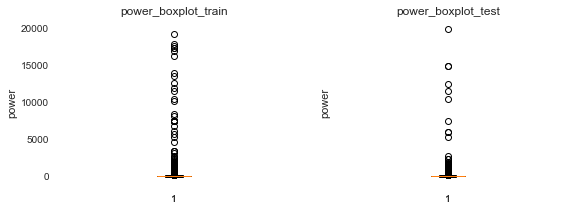

In [52]:
boxplot_train_test('power',train,test)

由上圖可看出，power有很多極大離群值。  
下面以小提琴圖輔助判斷極大離群值部分是否有密集現象：

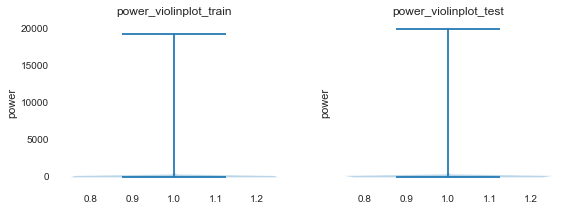

In [53]:
violinplot_train_test('power',train,test)

由小提琴圖可看出極大離群值並沒有明顯密集區段，故異常部分應為單純異常值。  
由字段表中描述判斷，power應該在[0,600]間，故以下統計不在範圍內的數據比例：

In [54]:
print('train power<0：{}%'.format(round(100*train[(train.power<0)].shape[0]/150000,2)))
print('train power>600：{}%'.format(round(100*train[(train.power>600)].shape[0]/150000,2)))

train power<0：0.0%
train power>600：0.1%


In [55]:
print('test power<0：{}%'.format(round(100*test[(test.power<0)].shape[0]/50000,2)))
print('test power>600：{}%'.format(round(100*test[(test.power>600)].shape[0]/50000,2)))

test power<0：0.0%
test power>600：0.14%


由上述判斷可知，離群值出現在>600部分，且比例極低，故去除此部分後再畫一次箱形圖以獲得準確分布狀況：

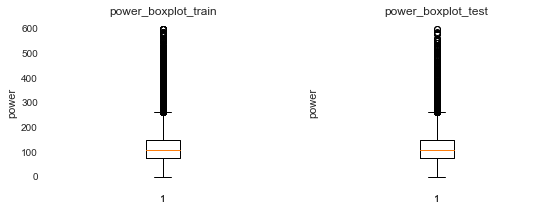

In [56]:
boxplot_train_test('power',train[(train.power<=600)],test[(test.power<=600)])

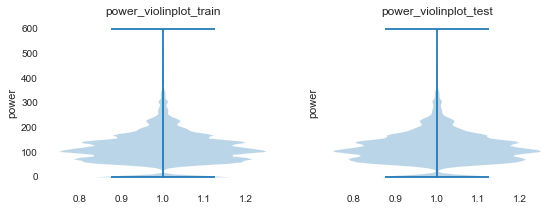

In [57]:
violinplot_train_test('power',train[(train.power<=600)],test[(test.power<=600)])

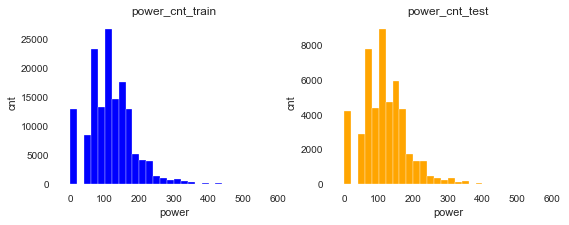

In [58]:
plot_count_by_column_hist('power',train[(train.power<=600)],test[(test.power<=600)],bins=30)

In [59]:
train[(train.power<=600)].power.describe()

count    149857.000000
mean        116.399941
std          68.500152
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         600.000000
Name: power, dtype: float64

In [60]:
# power=0雖按字段描述來說在範圍內，但實際上發動機功率為零並不合理
# 統計 power=0 占比
print('train data power=0 : {}%'.format(round(100*train[train.power==0].shape[0]/150000,2)))
print('test data power=0 : {}%'.format(round(100*test[test.power==0].shape[0]/50000,2)))

train data power=0 : 8.55%
test data power=0 : 8.39%


>由圖可看出，**過濾掉power>600部分**(約占0.1%)後，整體分布較為正常，且訓練和測試集分布狀況雷同。  
但其中power=0 (占比約8%) 或太小雖符合字段描述，但實際上並不合理，應考慮進一步分析處理。  
較大極值部分初步判斷為較少在二手車市場出現的特殊車輛。

**kilometer**

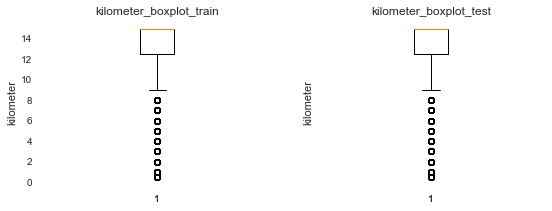

In [61]:
boxplot_train_test('kilometer',train,test)

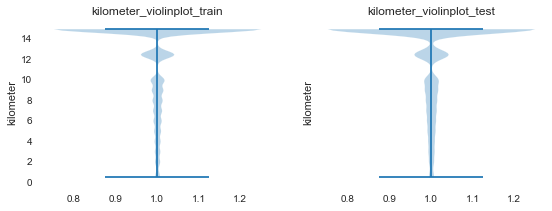

In [62]:
violinplot_train_test('kilometer',train,test)

In [63]:
# 因 kilometer 分布十分顆粒狀，故用value_counts() 再檢視細節：
train.kilometer.value_counts()

15.0    96877
12.5    15722
10.0     6459
9.0      5257
8.0      4573
7.0      4084
6.0      3725
5.0      3144
4.0      2718
3.0      2501
2.0      2354
0.5      1840
1.0       746
Name: kilometer, dtype: int64

In [64]:
test.kilometer.value_counts()

15.0    32189
12.5     5346
10.0     2106
9.0      1791
8.0      1523
7.0      1408
6.0      1218
5.0      1093
4.0       898
3.0       849
2.0       717
0.5       616
1.0       246
Name: kilometer, dtype: int64

>由上圖可知：
1. 訓練及測試集分布基本相同
2. kilometer並非連續變量，應為分箱選項。需特別注意分箱選項表示kilometer實際上是>15w的。 
3. 而分布情況來說，大多公里數>13w
4. 公里數是否有異常可以結合車齡進一步判斷

**v_0**

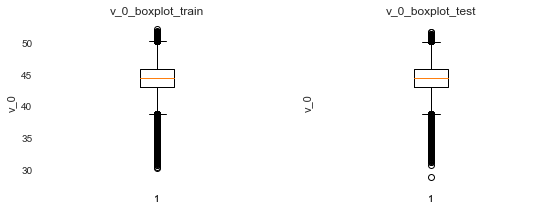

In [65]:
boxplot_train_test('v_0',train,test)

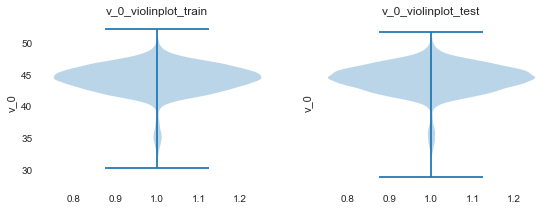

In [66]:
violinplot_train_test('v_0',train,test)

>在箱形圖中極大離群值分布區段並沒有密集分布現象，故極大異常應為單純異常或特殊規格車輛所致。  
而極小離群值部分，v_0=35 附近較密集的分布現象，原因待分析。

**v_1**

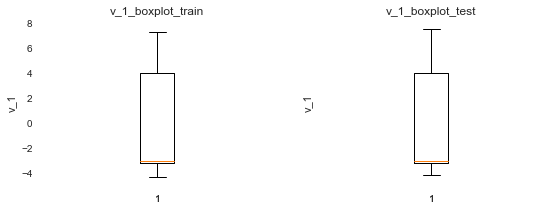

In [67]:
boxplot_train_test('v_1',train,test)

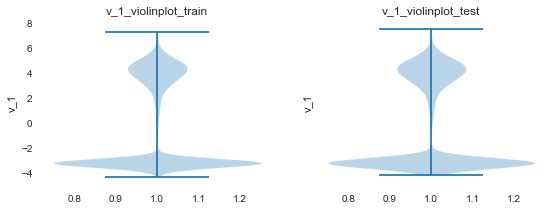

In [68]:
violinplot_train_test('v_1',train,test)

>訓練及測試集中 v_1 在 -3 及 4附近都分別有分群聚集的現象，原因待分析。

**v_2**

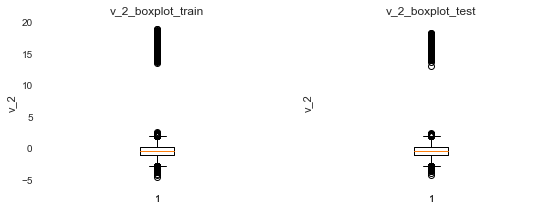

In [69]:
boxplot_train_test('v_2',train,test)

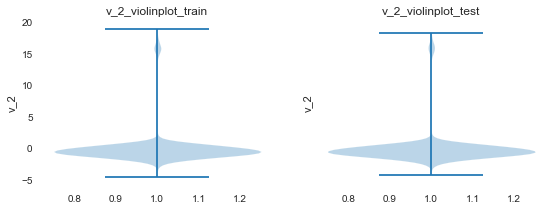

In [70]:
violinplot_train_test('v_2',train,test)

>訓練及測試集中 v_2 在 0 及 15 附近都分別有分群聚集的現象，原因待分析。

**v_3**

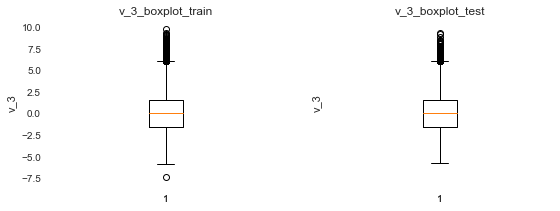

In [71]:
boxplot_train_test('v_3',train,test)

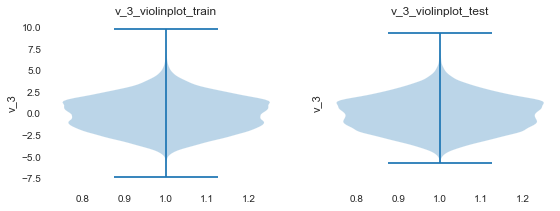

In [72]:
violinplot_train_test('v_3',train,test)

>訓練及測試集中 v_3 在 1 及 -1 附近都分別有聚集的現象，原因待分析。  
但小提琴圖中5-10並沒有樣本密集分布，故箱形圖中的極大離群值應為單純異常或特殊規格車輛所致。

**v_4**

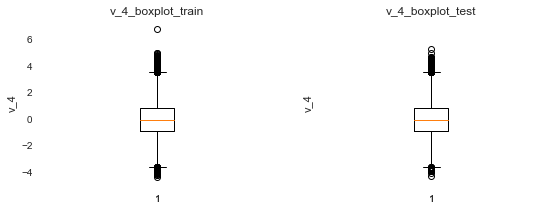

In [73]:
boxplot_train_test('v_4',train,test)

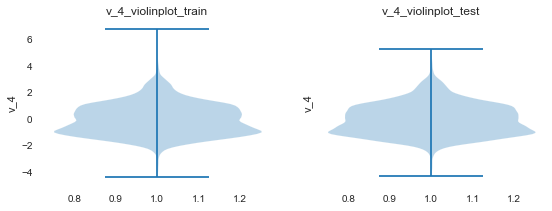

In [74]:
violinplot_train_test('v_4',train,test)

>訓練及測試集中 v_4 在 1 及 -1 附近都分別有聚集的現象，原因待分析。  
但密集狀況並未支持箱形圖中的極大離群值，故應為單純異常或特殊規格車輛所致。

**v_5**

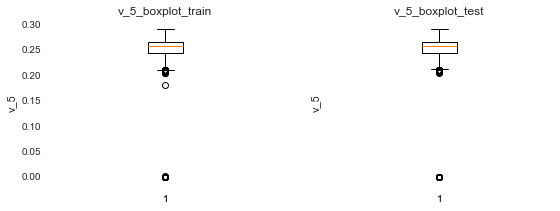

In [75]:
boxplot_train_test('v_5',train,test)

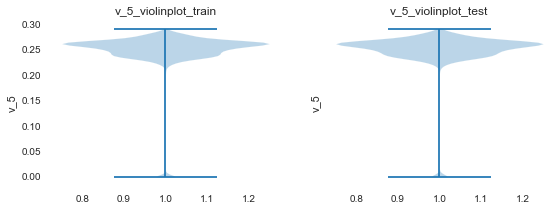

In [76]:
violinplot_train_test('v_5',train,test)

>訓練及測試集中 v_5 在 0 附近確實有密集現象，故箱形圖中極小離群值並非異常，此分段密集原因待分析。

**v_6**

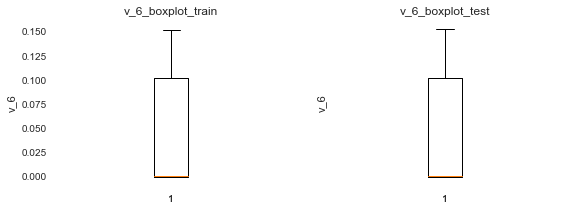

In [77]:
boxplot_train_test('v_6',train,test)

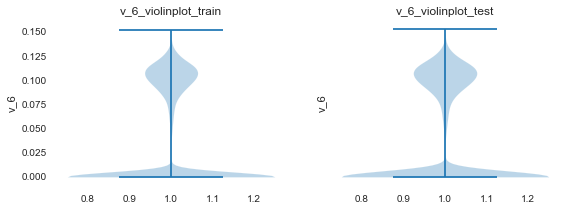

In [78]:
violinplot_train_test('v_6',train,test)

>訓練及測試集中 v_6 在 0.11 和 0 附近有分群密集現象，原因待分析。

**v_7**

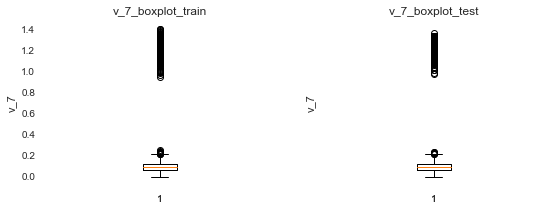

In [79]:
boxplot_train_test('v_7',train,test)

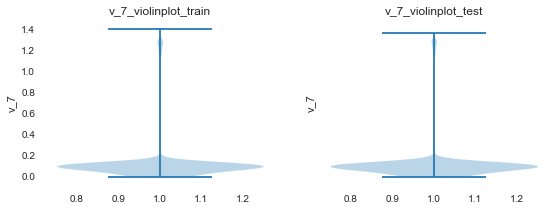

In [80]:
violinplot_train_test('v_7',train,test)

>訓練及測試集中 v_7 大部分集中在0.0-0.2間，但在1.3附近有小部分密集現象對應箱形圖中極大離群值部分，原因待分析。

**v_8**

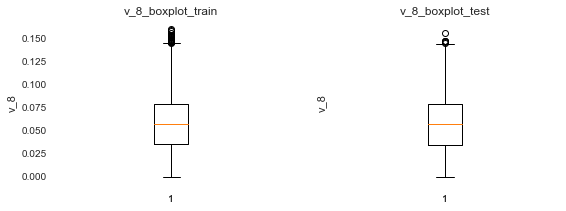

In [81]:
boxplot_train_test('v_8',train,test)

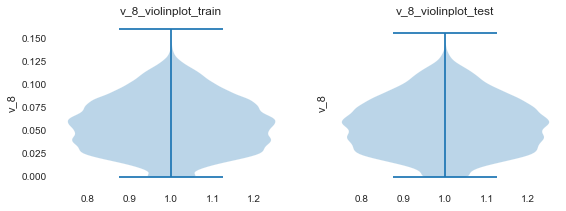

In [82]:
violinplot_train_test('v_8',train,test)

>訓練及測試集中 v_8 大部分集中在0.0-0.13間，其中0.06及0.04附近較高度密集，而箱形圖也顯示有較大量的極大異常值。

**v_9**

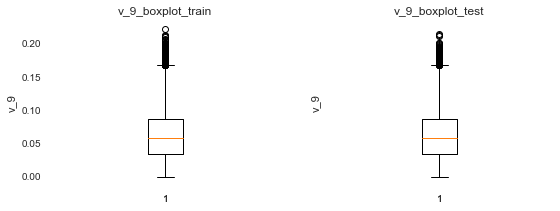

In [83]:
boxplot_train_test('v_9',train,test)

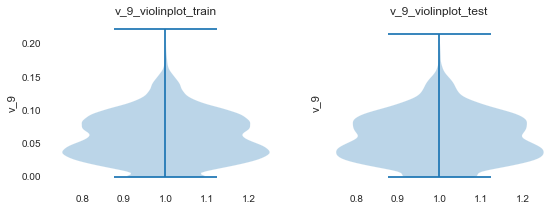

In [84]:
violinplot_train_test('v_9',train,test)

>訓練及測試集中 v_9 大部分集中在0.0-0.15間，其中0.075及0.04附近較高度密集，而箱形圖也顯示有較大量的極大異常值。

**v_10**

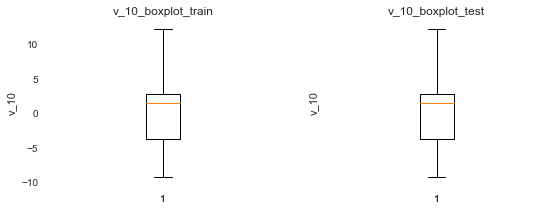

In [85]:
boxplot_train_test('v_10',train,test)

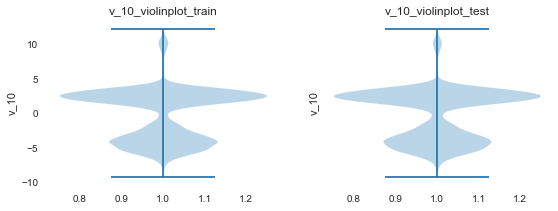

In [86]:
violinplot_train_test('v_10',train,test)

>訓練及測試集中 v_10 在 -5, 2.5, 10 附近都有較高度密集，原因待分析。

**v_10**

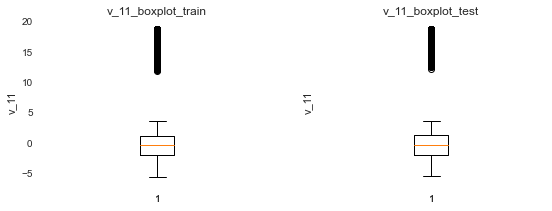

In [87]:
boxplot_train_test('v_11',train,test)

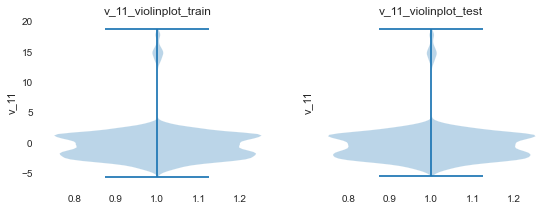

In [88]:
violinplot_train_test('v_11',train,test)

>訓練及測試集中 v_11 普遍分布在 -5 ~ 4 之間，且在 -2, 2 附近高度密集。此外，在15附近也有較高度密集，對應箱形圖中極大離群值，原因待分析。

**v_12**

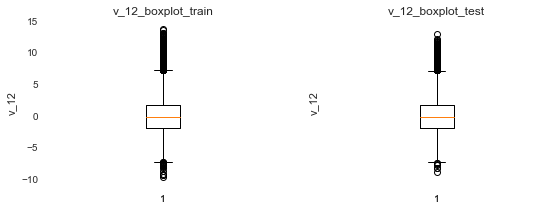

In [89]:
boxplot_train_test('v_12',train,test)

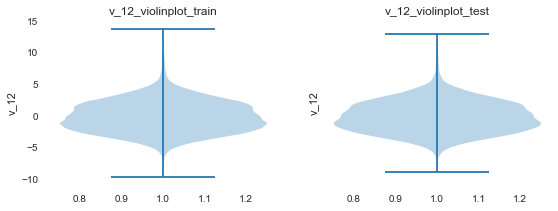

In [90]:
violinplot_train_test('v_12',train,test)

>訓練及測試集中 v_12 普遍分布在 -5 ~ 5 之間，但箱形圖中有大量極大離群值並未在小提琴圖中密集出現，可能為單純異常或特殊車輛。

**v_13**

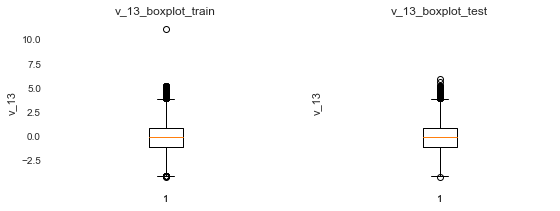

In [91]:
boxplot_train_test('v_13',train,test)

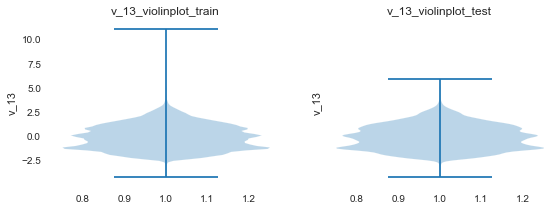

In [92]:
violinplot_train_test('v_13',train,test)

>訓練及測試集中 v_13 普遍分布在 -3 ~ 3 之間，箱形圖中有少量離群值，但相對來說不算異常。  
另外，需注意訓練集中有一個明顯異常值，需考慮剔除。

**v_14**

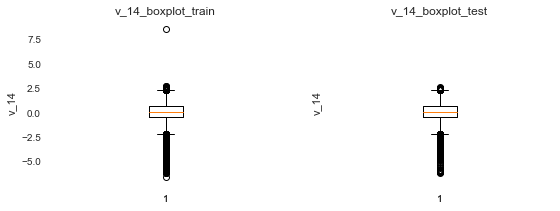

In [93]:
boxplot_train_test('v_14',train,test)

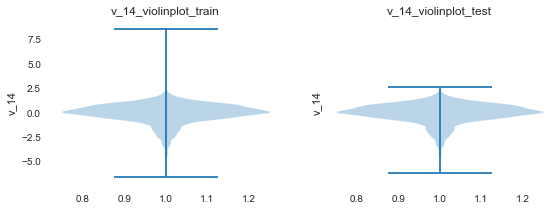

In [94]:
violinplot_train_test('v_14',train,test)

>訓練及測試集中 v_14 普遍分布在 -4 ~ 2 之間，箱形圖中有少量離群值，但相對來說不算異常。  
另外，需注意訓練集中有一個明顯異常值，需考慮剔除。

### 5. 預測目標 price

{'whiskers': [<matplotlib.lines.Line2D at 0x20d43b1c8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x20d4b5ebd68>,
 'boxes': [<matplotlib.lines.Line2D at 0x20d43b1cc18>],
 'medians': [<matplotlib.lines.Line2D at 0x20d4b728828>],
 'fliers': [<matplotlib.lines.Line2D at 0x20d4b728438>],
 'means': []}

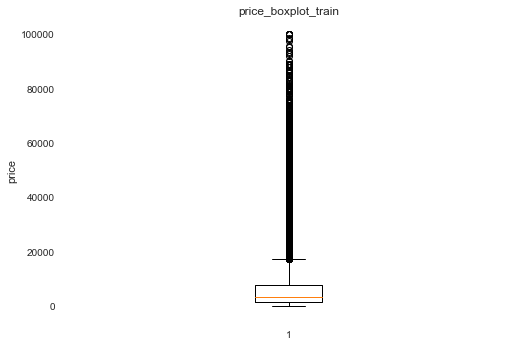

In [95]:
plt.ylabel('price')
plt.title("price_boxplot_train")
plt.boxplot(train['price'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x20d4b430710>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x20d4b64ea58>,
 'cmins': <matplotlib.collections.LineCollection at 0x20d4b430cc0>,
 'cbars': <matplotlib.collections.LineCollection at 0x20d4b430f98>}

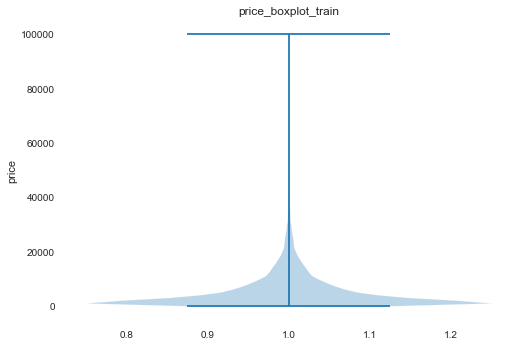

In [96]:
plt.ylabel('price')
plt.title("price_boxplot_train")
plt.violinplot(train['price'])

>價格分布偏低，初步推測價格數據經過預處理，可能經過對數轉換。  
另外，有很多極大離群值，需進一步探討這部分離群值是否有共通點。

## 五、相關性分析

### 1. 數值變量

In [97]:
# 數值變量列表
numeric_features = ['power'] + ['v_{}'.fof , ax = plt.subplots(figsize = (8, 8))
plt.title('numeric features & Price correlation')
sns.heatmap(corr,square = True, vmax=0.8)rmat(x) for x in range(0,15)]
print(numeric_features)

['power', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


In [98]:
# 計算數值變量+價格相互相關性
corr = train[numeric_features+['price']].corr()

In [99]:
# 檢視預測目標和變量間相關性
print(corr['price'])

power    0.219834
v_0      0.628397
v_1      0.060914
v_2      0.085322
v_3     -0.730946
v_4     -0.147085
v_5      0.164317
v_6      0.068970
v_7     -0.053024
v_8      0.685798
v_9     -0.206205
v_10    -0.246175
v_11    -0.275320
v_12     0.692823
v_13    -0.013993
v_14     0.035911
price    1.000000
Name: price, dtype: float64


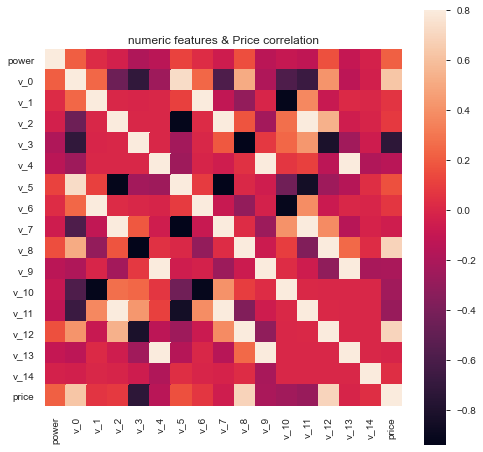

In [100]:
# 相關性可視化
f , ax = plt.subplots(figsize = (8, 8))
plt.title('numeric features & Price correlation')
sns.heatmap(corr,square = True, vmax=0.8)

>由相關性熱力圖可知：
+ 和預測目標 price 相關性特別高的有：  
    1. v_0 (+)
    2. v_3 (-)
    3. v_8 (+)
    4. v_12 (+) 
+ v特徵間普遍相關性高，後續特徵構建時需篩選或考慮降維處理。

In [101]:
# sns.set()
# sns_plot = sns.pairplot(train[numeric_features+['price']],size = 2 ,kind ='scatter',diag_kind='kde', plot_kws={"s": 1}, markers='+')
# sns_plot.savefig("num_features_pairplot.png")

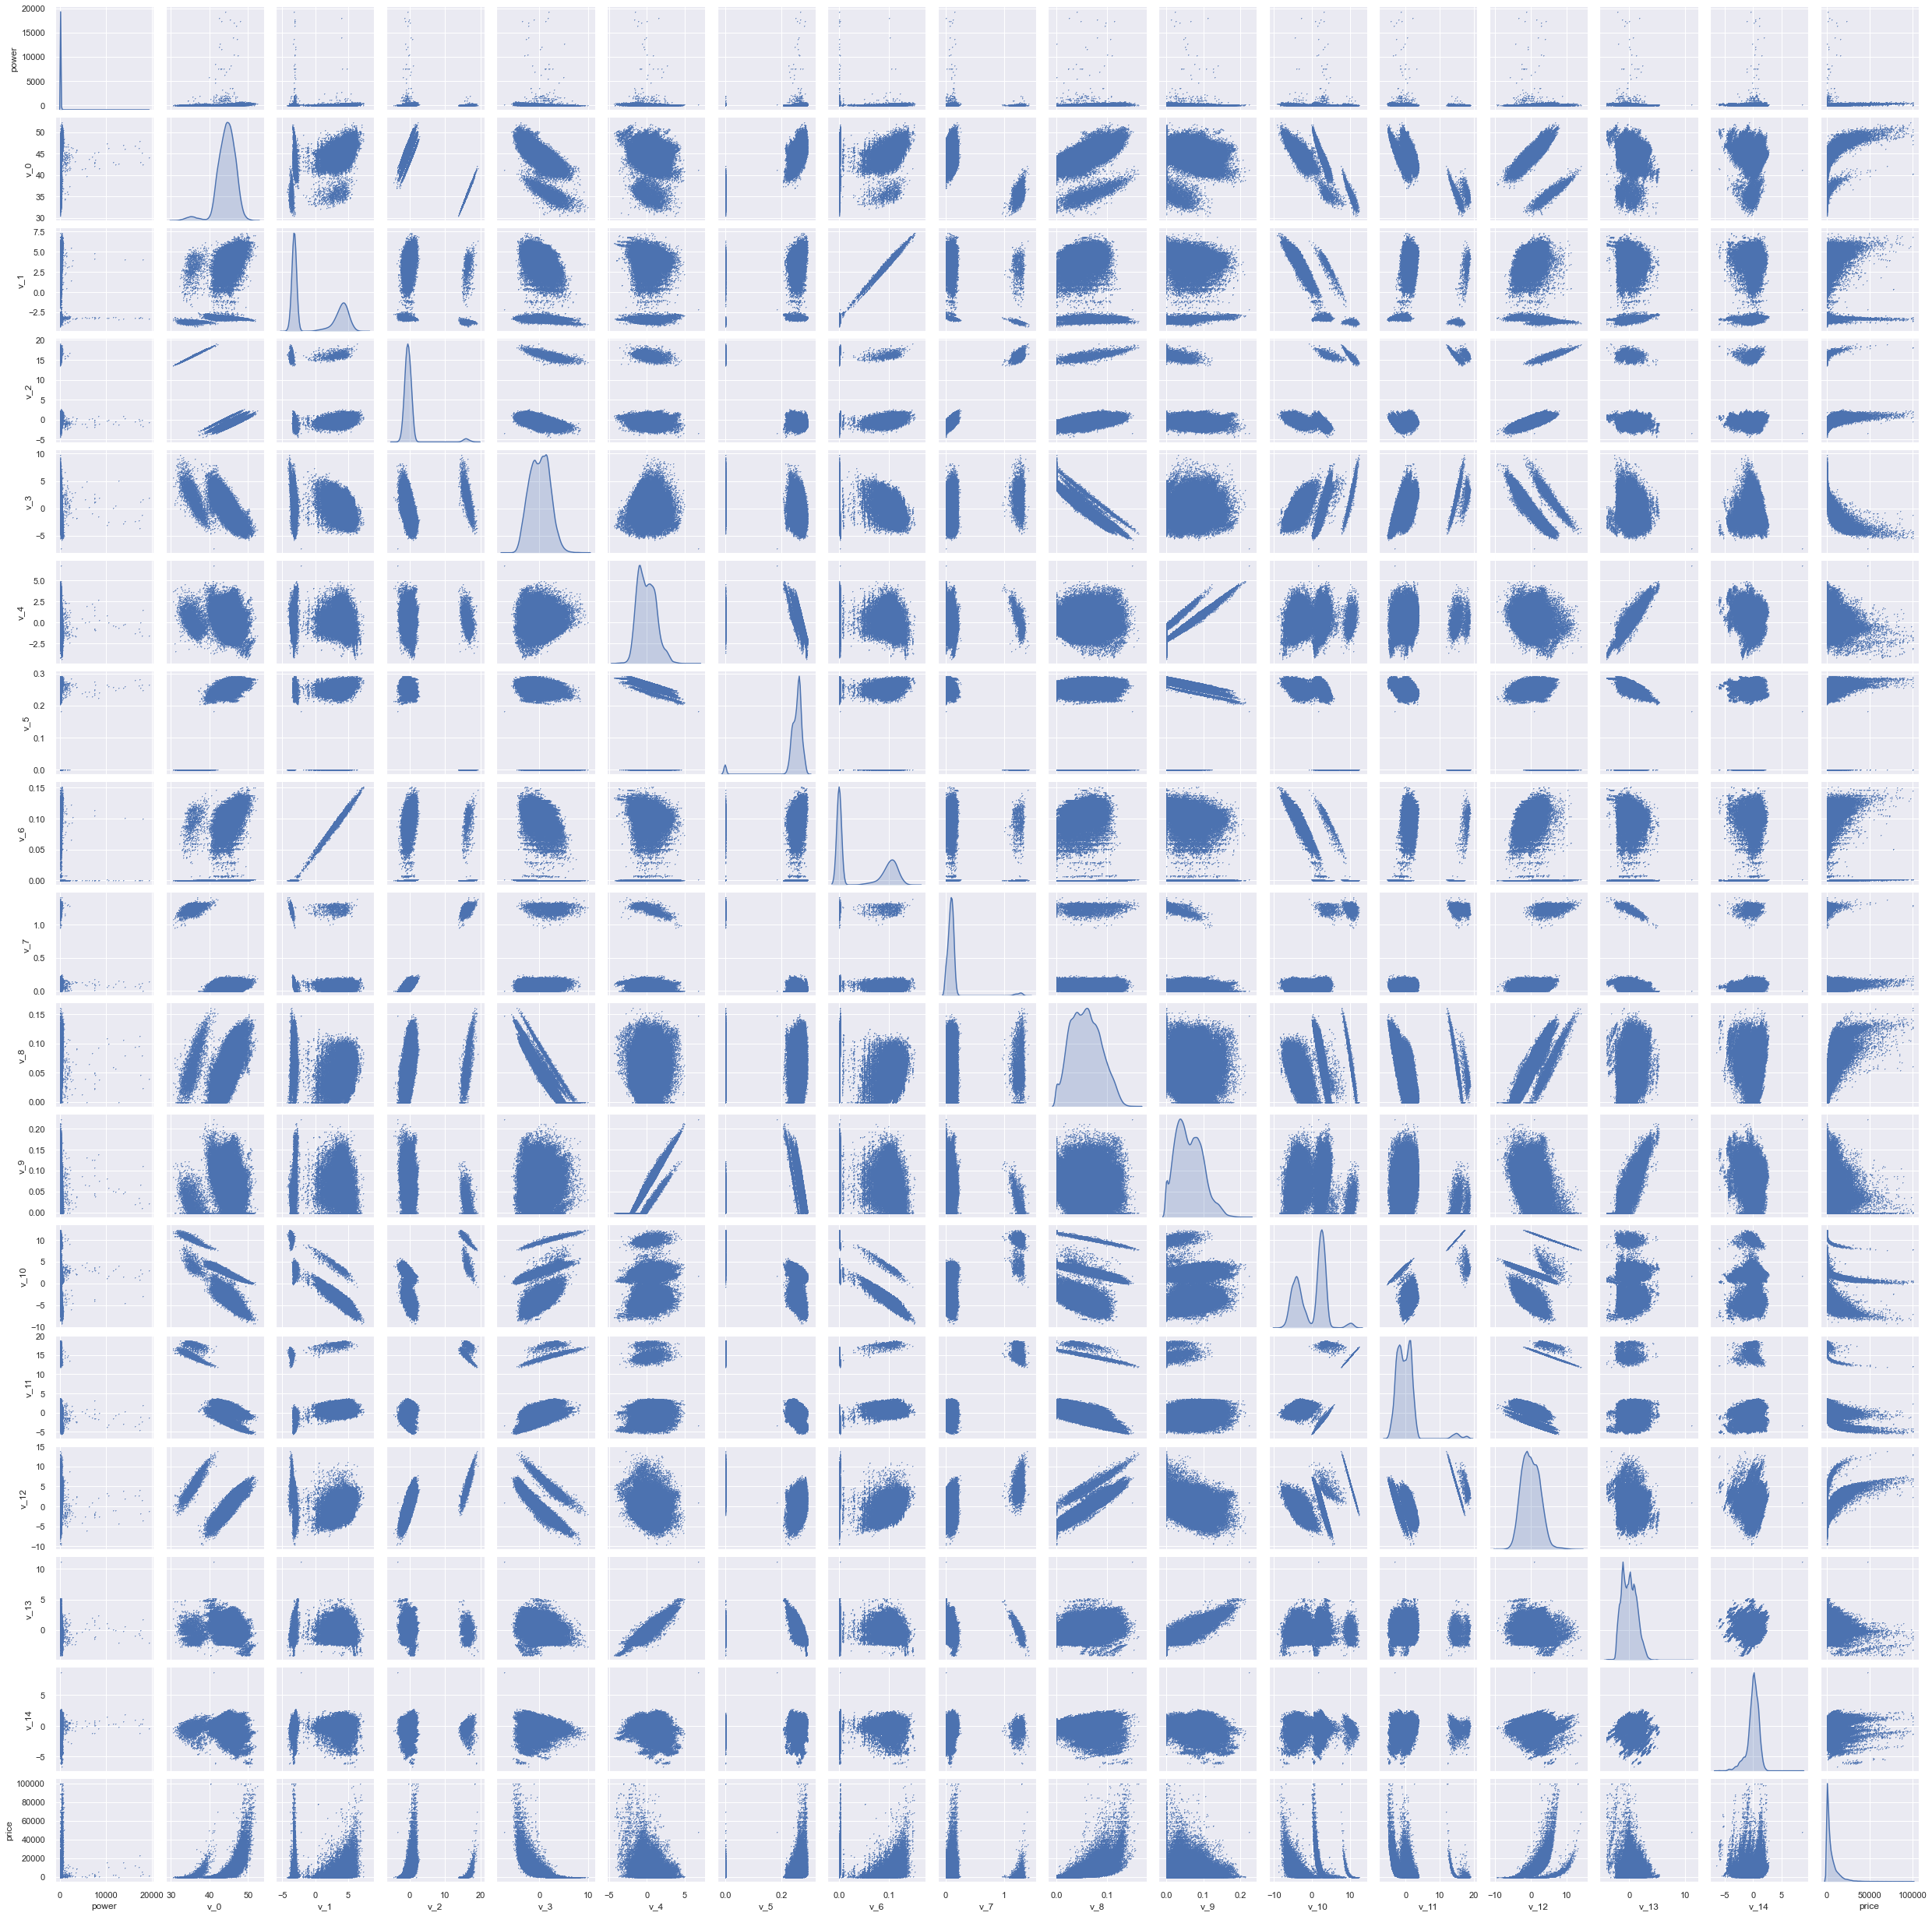

In [104]:
from IPython.display import Image
Image(filename='img/num_features_pairplot.png')

https://seaborn.pydata.org/generated/seaborn.pairplot.html

>由以上數值變量間的pairplot可以更詳細了解變量間的相關狀況(散點圖)以及變量自身的分布狀況(分布圖)。  
需別注意的是許多散點圖明顯分別散布成兩個區塊，部分v系列變量本身分布也明顯分為兩部分，後續分析需特別注意！

### 2. 類別變量

In [105]:
def boxplot_with_price_train_test(col,train):
    plt.ylabel(col)
    plt.title(col+"_boxplot_train")
    plt.boxplot([train[train[col]==cat].price for cat in train[train[col].isnull()==False][col].unique()],
               labels=(train[train[col].isnull()==False][col].unique()))

In [106]:
cat_features = ['brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'seller', 'offerType']

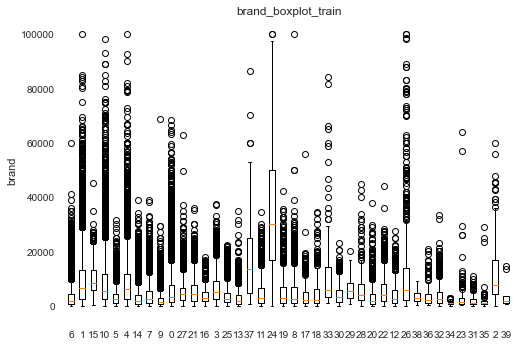

In [107]:
boxplot_with_price_train_test('brand',train)

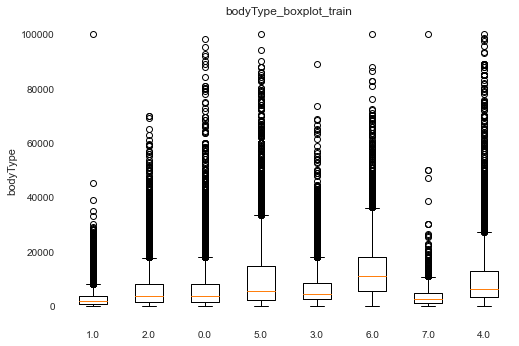

In [108]:
boxplot_with_price_train_test('bodyType',train)

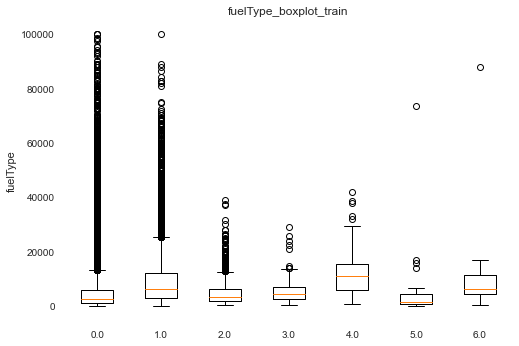

In [109]:
boxplot_with_price_train_test('fuelType',train)

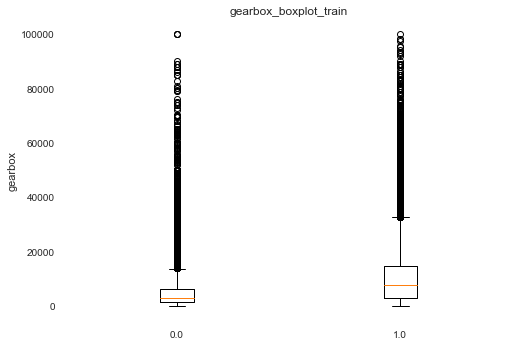

In [110]:
boxplot_with_price_train_test('gearbox',train)

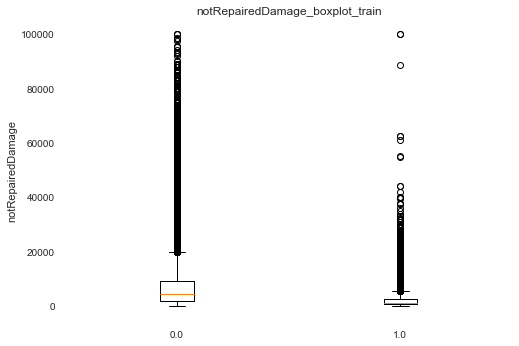

In [111]:
boxplot_with_price_train_test('notRepairedDamage',train)

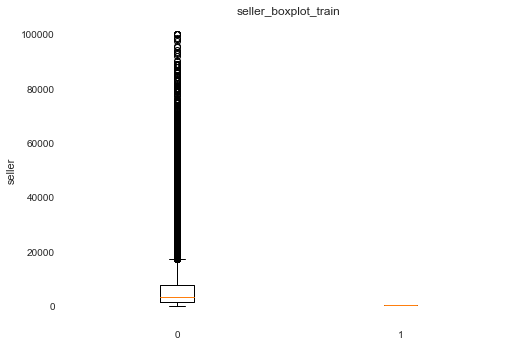

In [112]:
boxplot_with_price_train_test('seller',train)

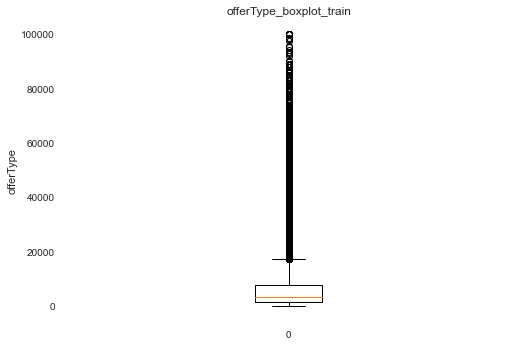

In [113]:
boxplot_with_price_train_test('offerType',train)

>除了seller和offerType因類別分布過於偏差無法判斷，其他類別變量皆有表現出其中部分類別總體價格偏高的現象，故都可作為特徵候選。

## 總結

### 變量類型、缺失值、異常值、分布狀況

| no | 字段名 | 描述 | 變量類型 | 缺失占比<br>(訓練,測試) | 缺失處理 | 異常值 | 分布 |
|---|:---|:---|:---|:---|:---|:---|:---|
| 01 | SaleID | 交易ID | 編碼 |||||
| 02 | name | 汽車交易名稱 | 編碼 |||| 數值較小部分汽車數量較多 |
| 03 | regDate | 汽車註冊日期 | 日期 ||| 月份有8%為0 | 日期只有1-12 |
| 04 | model | 車型編碼 | 編碼 | (~0%, 無) | 訓練集1筆缺失剔除 || 數值較小部分汽車數量較多 |
| 05 | brand | 汽車品牌 | 類別 |||| 數值較小部分汽車數量較多 |
| 06 | bodyType | 車身類型 | 類別 | (3%, 2.8%) | 需再分析處理 || 各類占比符合常識中各類車輛的普遍性 |
| 07 | fuelType | 燃油類型 | 類別 | (5.8%, 5.8%) | 需再分析處理 || 各類占比符合常識中各種燃油車輛的普遍性 |
| 08 | gearbox | 變速箱 | 類別 (01) | (4%, 3.8%) | 需再分析處理 || 大部分駕駛偏好手動？<br>是否影響自動車輛市場價格？ |
| 09 | power | 發動機功率 | 數值 ||| 約0.1%數據>600為異常值；<br>power=0或太小雖符合字段描述，但實際上並不合理，需再分析處理| 有極大離群值初步判斷為特殊車輛，需再分析 |
| 10 | kilometer | 已行駛公里(萬km) | 數值 ||| 公里數是否有合理需結合車齡進一步判斷 | 並非連續變量，應為分箱選項；<br>大部分>13w，最大值15w因為是分箱數據，所以極可能有大部分>15w |
| 11 | notRepairedDamage | 有尚未修復的損壞 | 類別 (01) | (16%, 16%)<sup>***註1***</sup> | 需再分析處理 || 大多有尚未修復損壞，可考慮和車齡或公里數結合判斷車況 |
| 12 | regionCode | 地區編碼 | 編碼 |||| 數值較小部分汽車數量相對較多 |
| 13 | seller | 銷售方 | 類別 (01) |||| 幾乎全部為個體賣家，僅訓練集中有1筆非個體賣家數據，不宜作為特徵 |
| 14 | offerType | 報價類型 | 類別 (01) |||| 所有數據都是offerType=0，不宜作為特徵 |
| 15 | creatDate | 上線時間 | 日期 |||| 年份2016占絕大多數，不宜作為特徵；<br>月份大部分在3月，其次4月，分布過於不平衡。 |
| 16 | price | 二手車交易價格（預測目標）| 數值 |||| 價格分布偏低，初步推測經過對數轉換或其他預處理。<br>有很多極大離群值，可再挖掘這些離群值是否有共通點。 |
| 17-31 | v_0-v_14 | 匿名特徵 | 數值 ||| v_14 訓練集中有1個明顯極大離群值需剔除 | 許多v系列特徵有分段聚集的現象，需再分析 |

***註1*** 缺失部分以字符串'-'表示，故數字部分也以字符串形式讀取。 因此缺失的'-'部分需替換為空值，並將整個字段轉為float形式。

### 相關性分析

>**變量 vs price**  
1.數值變量：和 v_0 (+)、v_3 (-)、v_8 (+)、v_12(+) 相關性高
2.類別變量：除了seller和offerType因分布不均衡無法判斷，其他類別變量皆有部分類別總體價格偏高的現象  

>**變量間**   
1.數值變量：v系列特徵間相關性偏高，可考慮降維處理

***第一次的EDA主要目的只是初步了解特徵狀況並找到必需處理的數據缺失異常，幫助快速開展後續特徵工程及建模工作，之後會再依照預測結果回頭對特徵進行進一步挖掘。因此這一個步驟只需將所有特徵以一個相對標準的方式做分析，不需要做過多的挖掘。***